In [1]:
import awkward as ak
import pathlib
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, MultipleLocator, ScalarFormatter, AutoMinorLocator
from scipy.optimize import curve_fit
import atlas_mpl_style as ampl
#ampl.use_atlas_style()
#from codes.plotting import plot_prettier 
#plot_prettier()

In [2]:
pt_0_50 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\v0_noBIB_0-50.json"))
pt_50_250 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\v0_noBIB_50-250.json"))
pt_250_1000 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\v0_noBIB_250-1000.json"))
legacy = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\makeMuonPlots.json"))

In [3]:
mcp_pt = pt_250_1000['mcp_pt']
mcp_eta = pt_250_1000['mcp_eta']
mcp_phi = pt_250_1000['mcp_phi']
pfo_pt = pt_250_1000['pfo_pt']
pfo_eta = pt_250_1000['pfo_eta']
pfo_phi = pt_250_1000['pfo_phi']
pfo_mu_pt = pt_250_1000['pfo_mu_pt']
pfo_mu_eta = pt_250_1000['pfo_mu_eta']
pfo_mu_phi = pt_250_1000['pfo_mu_phi']
mcp_mu_pt = pt_250_1000['mcp_mu_pt']
mcp_mu_eta = pt_250_1000['mcp_mu_eta']
mcp_mu_phi = pt_250_1000['mcp_mu_phi']
mcp_mu_match_pt = pt_250_1000['mcp_mu_match_pt']
mcp_mu_match_eta = pt_250_1000['mcp_mu_match_eta']
mcp_mu_match_phi = pt_250_1000['mcp_mu_match_phi']
d_mu_dpt = pt_250_1000['d_mu_dpt']
d_mu_drelpt = pt_250_1000['d_mu_drelpt']
d_mu_dphi = pt_250_1000['d_mu_dphi']
d_mu_deta = pt_250_1000['d_mu_deta']
nhits = pt_250_1000['nhits']
pt_res_hits = pt_250_1000['pt_res_hits']
# pt_res_vs_eta = pt_250_1000['pt_res_vs_eta']
# pt_res_vs_pt = pt_250_1000['pt_res_vs_pt']
# d0_res_vs_pt = pt_250_1000['d0_res_vs_pt']
# d0_res_vs_eta = pt_250_1000['d0_res_vs_eta']
# z0_res_vs_pt = pt_250_1000['z0_res_vs_pt']
# z0_res_vs_eta = pt_250_1000['z0_res_vs_eta']
d0_res = pt_250_1000['d0_res']
z0_res = pt_250_1000['z0_res']
pt_res = pt_250_1000['pt_res'] 
pt_match = pt_250_1000['pt_match']
eta_match = pt_250_1000['eta_match']
ndf = pt_250_1000['ndf']
chi2 = pt_250_1000['chi2']
d0_res_match = pt_250_1000['d0_res_match']
z0_res_match = pt_250_1000['z0_res_match']
h2d_relpt = pt_250_1000['h_2d_relpt']

In [4]:
# pt_res = ak.concatenate([pt_250_1000['pt_res'],pt_50_250['pt_res'],pt_0_50['pt_res']],axis=0) 
# pt_match = ak.concatenate([pt_250_1000['pt_match'],pt_50_250['pt_match'],pt_0_50['pt_match']],axis=0)
# eta_match = ak.concatenate([pt_250_1000['eta_match'],pt_50_250['eta_match'],pt_0_50['eta_match']],axis=0)
# ndf = ak.concatenate([pt_250_1000['ndf'],pt_50_250['ndf'],pt_0_50['ndf']],axis=0)
# chi2 = ak.concatenate([pt_250_1000['chi2'],pt_50_250['chi2'],pt_0_50['chi2']],axis=0)
# d0_res_match = ak.concatenate([pt_250_1000['d0_res_match'],pt_50_250['d0_res_match'],pt_0_50['d0_res_match']],axis=0)
# z0_res_match = ak.concatenate([pt_250_1000['z0_res_match'],pt_50_250['z0_res_match'],pt_0_50['z0_res_match']],axis=0)

In [5]:
theta_match = 2 * np.arctan(np.exp(-eta_match))
print(eta_match)
print(theta_match)
theta_match = np.degrees(theta_match)
print(theta_match)

theta_0_50 = np.degrees(2*np.arctan(np.exp(-pt_0_50['eta_match'])))
print(theta_0_50)
theta_50_250 = np.degrees(2*np.arctan(np.exp(-pt_50_250['eta_match'])))
print(theta_50_250)
theta_250_1000 = np.degrees(2*np.arctan(np.exp(-pt_250_1000['eta_match'])))
print(theta_250_1000)

[[0.741], [0.87], [-1.05], [0.541], ..., [0.388], [0.14], [1.49], [0.0579]]
[[0.889], [0.794], [2.47], [1.05], [2.38], ..., [1.19], [1.43], [0.445], [1.51]]
[[51], [45.5], [141], [60.4], [136], ..., [71.7], [68.3], [82], [25.5], [86.7]]
[[75.7], [160], [53.6], [48], [152], ..., [87.5], [44.4], [134], [20.9], [54.8]]
[[91.2], [55.1], [163], [63.7], [94.6], ..., [132], [148], [80.6], [155], [108]]
[[51], [45.5], [141], [60.4], [136], ..., [71.7], [68.3], [82], [25.5], [86.7]]


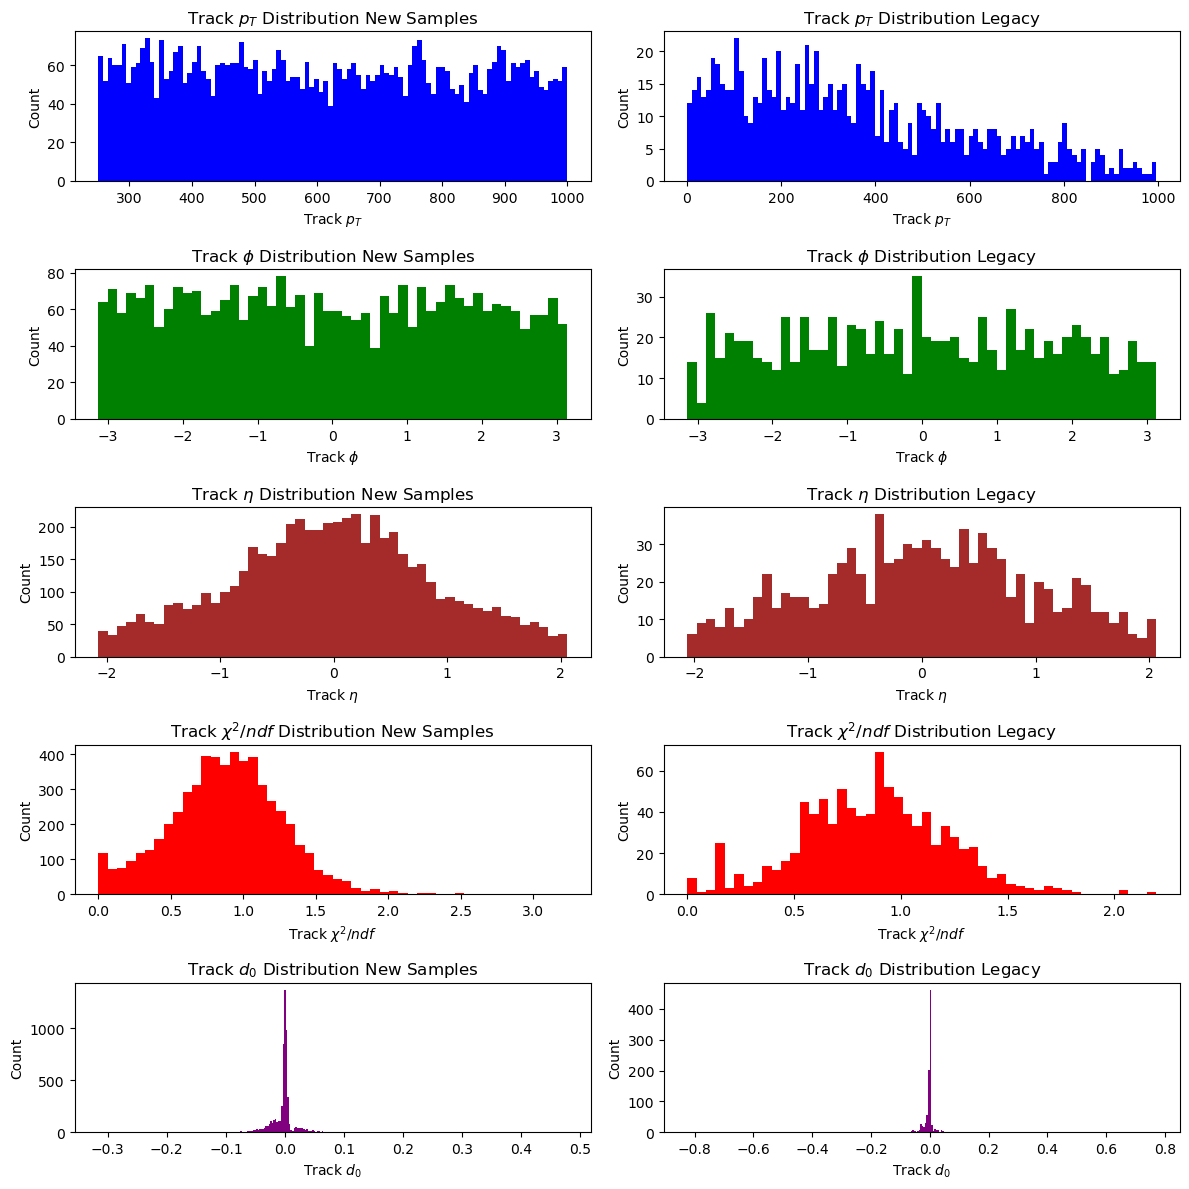

In [6]:
# Create histograms
plt.figure(figsize=(12, 12))

# Histogram for track pt
plt.subplot(5, 2, 1)
plt.hist(ak.flatten(pt_match), bins=100, color='blue')
plt.xlabel('Track $p_T$')
plt.ylabel('Count')
plt.title('Track $p_T$ Distribution New Samples')

plt.subplot(5, 2, 2)
plt.hist(ak.flatten(legacy['pt_match']), bins=100, color='blue')
plt.xlabel('Track $p_T$')
plt.ylabel('Count')
plt.title('Track $p_T$ Distribution Legacy')

# Histogram for track phi
plt.subplot(5, 2, 3)
plt.hist(ak.flatten(mcp_mu_match_phi), bins=50, color='green')
plt.xlabel(r'Track $\phi$')
plt.ylabel('Count')
plt.title(r'Track $\phi$ Distribution New Samples')

plt.subplot(5, 2, 4)
plt.hist(ak.flatten(legacy['mcp_mu_match_phi']), bins=50, color='green')
plt.xlabel(r'Track $\phi$')
plt.ylabel('Count')
plt.title(r'Track $\phi$ Distribution Legacy')

# Histogram for track eta
plt.subplot(5, 2, 5)
plt.hist(ak.flatten(eta_match), bins=50, color='brown')
plt.xlabel(r'Track $\eta$')
plt.ylabel('Count')
plt.title(r'Track $\eta$ Distribution New Samples')

plt.subplot(5, 2, 6)
plt.hist(ak.flatten(legacy['eta_match']), bins=50, color='brown')
plt.xlabel(r'Track $\eta$')
plt.ylabel('Count')
plt.title(r'Track $\eta$ Distribution Legacy')

# Histogram for track ndf
plt.subplot(5, 2, 7)
plt.hist(ak.flatten(chi2)/ak.flatten(ndf), bins=50, color='red')
plt.xlabel(r'Track $\chi^2/ndf$')
plt.ylabel('Count')
plt.title(r'Track $\chi^2/ndf$ Distribution New Samples')

plt.subplot(5, 2, 8)
plt.hist(ak.flatten(legacy['chi2'])/ak.flatten(legacy['ndf']), bins=50, color='red')
plt.xlabel(r'Track $\chi^2/ndf$')
plt.ylabel('Count')
plt.title(r'Track $\chi^2/ndf$ Distribution Legacy')

# Histogram for track d0
plt.subplot(5, 2, 9)
plt.hist(ak.flatten(d0_res_match), bins=300, color='purple')
plt.xlabel('Track $d_0$')
plt.ylabel('Count')
plt.title(r'Track $d_0$ Distribution New Samples')
#plt.xlim(-0.1, 0.1)

plt.subplot(5, 2, 10)
plt.hist(ak.flatten(legacy['d0_res_match']), bins=300, color='purple')
plt.xlabel('Track $d_0$')
plt.ylabel('Count')
plt.title('Track $d_0$ Distribution Legacy')
#plt.xlim(-0.1, 0.1)

# Adjust subplot spacing
plt.tight_layout()

# Display the histograms
plt.show()


### Binning impact parameters by $p_T$ (NB: this code is for legacy data)

In [7]:
pT_ranges = [1,100, 500, np.inf]  # The last value should be np.inf to cover 200+ GeV

# Define relaxed cutoffs for lower pT ranges
pT_d0_cutoffs = [0.8, 0.7, 0.6, 0.5]  
pT_z0_cutoffs = [1.8, 1.7, 1.6, 1.5]  

# Initialize the target arrays with NaN values to preserve the dtype
d0_masked = []
z0_masked = []
pt_res_masked = []
pt_masked_d0 = []
pt_masked_z0 = []
theta_masked_d0 = []
theta_masked_z0 = []

# Create subsets of legacy for different pT ranges and apply resolution cutoffs
for i in range(len(pT_ranges) - 1):
    pT_min = pT_ranges[i]
    pT_max = pT_ranges[i + 1]

    # Create a mask for the current pT range
    mask = np.array([pT_min <= x[0] < pT_max for x in pt_match])  

    # Apply resolution cutoffs for d0 and z0
    d0_cutoff = np.array([x[0] < pT_d0_cutoffs[i] for x in d0_res_match])
    z0_cutoff = np.array([x[0] < pT_z0_cutoffs[i] for x in z0_res_match])
    theta_cutoff = np.array([70 <= x[0] < 110 for x in theta_match])
    d0_mask = mask & d0_cutoff & theta_cutoff
    z0_mask = mask & z0_cutoff & theta_cutoff
    # Create subsets of legacy for the current pT range and apply the resolution cutoffs
    #pT_subset = pt_match[mask]
    d0_masked.append(d0_res_match[d0_mask])
    z0_masked.append(z0_res_match[z0_mask])
    dpT_pt = []
    for x, y in zip(pt_res[d0_mask], pt_match[d0_mask]):
        dpT_pt.append([x[0] / y[0]])
    pt_res_masked.append(dpT_pt)  
    pt_masked_d0.append(pt_match[d0_mask])
    pt_masked_z0.append(pt_match[z0_mask])
    theta_masked_d0.append(theta_match[d0_mask])
    theta_masked_z0.append(theta_match[z0_mask])
    print('# of points in pT range', pT_min, '-', pT_max, '=', len(theta_match[d0_mask]))
print(pt_res_masked)
print(theta_masked_d0)
# print(len(d0_masked))
# print(len(theta_masked_d0))
# for i in range(len(d0_masked)):
#     print(len(d0_masked[i]))
#     print(len(theta_masked_d0[i]))

# of points in pT range 1 - 100 = 0
# of points in pT range 100 - 500 = 618
# of points in pT range 500 - inf = 1111
[[], [[-1.5582159866221187e-05], [-1.8016480525008983e-05], [-2.223865583282629e-05], [-0.005480784931678448], [-2.5733507691682747e-05], [6.606633806757963e-06], [0.0011371579693222663], [1.259531300497628e-05], [8.236020976593938e-06], [-3.5438474510626215e-05], [-2.0328795164840223e-07], [-5.0571230483673844e-06], [-3.3639072282217618e-06], [-0.002071461073631595], [-3.4614841808389026e-05], [-3.880697740239672e-05], [-2.2986525289854694e-07], [-5.781498282168535e-06], [1.3833089852429184e-05], [0.0022898988850909097], [-3.400242699427204e-05], [-1.1490502508878072e-05], [-2.5965945191994313e-06], [2.8486078338160338e-05], [9.368006814236679e-06], [2.620116472086367e-06], [2.2017584496075457e-05], [2.564646938531169e-06], [-1.9707623577921465e-06], [-8.73360894148555e-06], [-5.123112310699129e-06], [2.1799507097703817e-05], [1.8069675737421475e-05], [4.77155877889915e

### Plotting Functions

In [8]:
# Function for creating a Gaussian fit
def gaussian(x, a, mu, sigma):
    return a * np.exp(-0.5 * ((x - mu) / sigma)**2)

def fit_gaussian(slice_data, bins=np.linspace(-0.5, 0.5, 100), mean = 0, rms = 0.01):
    if mean is None:
        mean = np.mean(slice_data)
    if rms is None:
        rms = np.sqrt(np.mean(np.square(slice_data - mean)))
    counts, bin_edges = np.histogram(slice_data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=[max(counts), mean, rms])
    return popt, pcov, bin_centers

##############################################################################################################################################################################################################################
# Function for plotting RMS vs. eta/theta/pT for multiple pT bins

def plotrms_multi(datax, datay, bins, labels=None, xlabel = '', ylabel='', title=''):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    
    for j in range(len(datay)):
        data_flatx = np.array(np.ravel(datax[j])).T
        data_flaty = np.array(np.ravel(datay[j])).T
        x_bins = np.linspace(data_flatx.min(), data_flatx.max(), bins + 1)
        rms_values = []
        sem_values = []
        for i in range(bins):
            slice_data = data_flaty[(data_flatx >= x_bins[i]) & (data_flatx < x_bins[i + 1])]
            try:
                # Fit a Gaussian to the slice data using the fit_gaussian function
                popt, pcov, bin_centers = fit_gaussian(slice_data)
                fitted_mean = popt[1]
                fitted_rms = popt[2]
            except RuntimeError:
                print(f"Could not fit Gaussian for Slice {i}.")
                rms = np.sqrt(np.mean(np.square(slice_data - np.mean(slice_data))))
                rms_values.append(rms)
                #sem_values.append(np.std(x_bin_data, ddof=1) / np.sqrt(len(x_bin_data)))
                continue            
            # sem = np.std(slice_data, ddof=1) / np.sqrt(len(slice_data))
            # if np.isnan(sem) or sem == 0:
            #     continue  # Skip bins with zero or NaN standard deviation
            rms_values.append(fitted_rms)
            #sem_values.append(sem)

        ax.errorbar((x_bins[:-1] + x_bins[1:]) / 2, rms_values, xerr = (data_flatx.max()-data_flatx.min())/(2*bins), fmt='o', markersize=4, label=labels[j])#, linestyle='-')
        #ax.scatter((x_bins[:-1] + x_bins[1:]) / 2, rms_values, label=labels[j])#, linestyle='-')
    # title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    # xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]     
    # ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    ax.set_title(title)
    ax.set_xlabel(xlabel)#, fontsize=8)
    ax.set_ylabel(ylabel)#, fontsize=8)
    ax.set_yscale('log')
    # Set custom major and minor tick positions
    # major_locator = LogLocator(base = 10.0, numticks=5)
    # minor_locator = LogLocator(base = 10.0, numticks=25)
    # ax.yaxis.set_major_locator(major_locator)
    # ax.yaxis.set_minor_locator(minor_locator)
    # # Customize tick label formatting
    # ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.legend()
    plt.show()

##############################################################################################################################################################################################################################
# Function for plotting RMS vs. eta/theta/pT

def plotrms(datax, datay, bins, label="", xlim=None, ylim=None):
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    
    if xlim is not None:
        x_bins = np.linspace(xlim[0], xlim[1], bins + 1)
    else:
        x_bins = np.linspace(data_flatx.min(), data_flatx.max(), bins + 1)
    
    rms_values = []
    sem_values = []
    
    for i in range(bins):
        # Select data points within the specified x slice
        slice_data = data_flaty[(data_flatx >= x_bins[i]) & (data_flatx < x_bins[i + 1])]
        #print("Bin", i, "has", len(slice_data), "data points")
        try:
            popt, pcov, bin_centers = fit_gaussian(slice_data)
            fitted_mean = popt[1]
            fitted_rms = popt[2]
            sem_values.append(np.sqrt(pcov[2, 2]))
            rms_values.append(fitted_rms)
        except RuntimeError:
            print(f"Could not fit Gaussian for Slice {i}.")
            rms_values.append(np.sqrt(np.mean(np.square(slice_data - np.mean(slice_data)))))
            sem_values.append(np.std(slice_data, ddof=1) / np.sqrt(len(slice_data)))
            continue
        
        #print(f"Iteration {i}, rms_values size: {len(rms_values)}, sem_values size: {len(sem_values)}")

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)

    ax.errorbar((x_bins[:-1] + x_bins[1:]) / 2, rms_values, yerr = sem_values, xerr = (data_flatx.max()-data_flatx.min())/(2*bins), color = 'darkblue', fmt='o', markersize=4)#, linestyle='-')
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]     
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    ax.set_title(title)
    ax.set_xlabel(xlabel)#, fontsize=8)
    ax.set_ylabel(ylabel)#, fontsize=8)
    ax.set_yscale('log')
    if ylim is not None:
            ax.set_ylim(ylim[0], ylim[1])
    plt.show()

##############################################################################################################################################################################################################################
# Function for plotting a 1D histogram and fitting a Gaussian to it

def plotrms_slice(datax, datay, x_bins, bins, title="", rv = False, sigma5 = False):
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T

    for i in range(len(x_bins)-1):
        # Select data points within the specified x slice
        slice_data = data_flaty[(data_flatx >= x_bins[i]) & (data_flatx < x_bins[i + 1])]
        gaussian_fit = True
        try:
            # Fit a Gaussian to the slice data using the fit_gaussian function
            popt, pcov, bin_centers = fit_gaussian(slice_data, bins, mean = None, rms = None)
            fitted_mean = popt[1]
            fitted_rms = popt[2]
        except RuntimeError:
            print(f"Could not fit Gaussian for Slice {i}.")
            gaussian_fit = False
            continue

        # Print the values
        print(f"Slice {i}:", x_bins[i], 'to', x_bins[i + 1])
        #print("Actual Mean:", actual_mean)
        print("Mean from Fit:", fitted_mean)
        #print("Actual RMS:", actual_rms)
        print("Sigma from Fit:", fitted_rms)
        print("------------------------------------")

        # Plot the 1D histogram with the Gaussian fit
        plt.hist(slice_data, bins, alpha=0.5, label='Data')
        if gaussian_fit:
            plt.plot(bin_centers, gaussian(bin_centers, *popt), 'r--', label='Gaussian Fit')
        if sigma5 == True:
            plt.axvline(x=fitted_mean - 5*np.abs(fitted_rms), linestyle='dotted', color='green', label=f'-5$\sigma$ = {fitted_mean - 5*np.abs(fitted_rms)}')
            plt.axvline(x=fitted_mean + 5*np.abs(fitted_rms), linestyle='dotted', color='green', label=f'+5$\sigma$ = {fitted_mean + 5*np.abs(fitted_rms)}')
        plt.ylabel('Counts')
        plt.xlabel(title, fontsize = 15)#+ f' for Slice {i}')
        #plt.yscale('log')
        plt.legend()
        plt.show()
        if rv == True:
            return fitted_rms, fitted_mean

##############################################################################################################################################################################################################################
# 2D Histogram plotting function

def plot2DHistogram(datax, datay, bins=100, norm="log", label="", xlim = None, ylim = None, stats = True):
    
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    #print(len(data_flatx),data_flatx)
    #print(len(data_flaty),data_flaty)
    
    fig = plt.figure(figsize=(4.5,3))
    ax = fig.add_subplot(111)

    hh = ax.hist2d(data_flatx, data_flaty, bins=bins, norm=norm, cmap="viridis")
    
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2]  
    zlabel = "" if len(label.split(";")) < 4 else label.split(";")[3] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)#, fontsize=8)
    ax.set_ylabel(ylabel)#, fontsize=8)
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

    if stats == True:
        # Calculate statistics
        num_entries = len(data_flatx)
        mean_x = np.mean(data_flatx)
        mean_y = np.mean(data_flaty)
        std_x = np.std(data_flatx)
        std_y = np.std(data_flaty)
        # Calculate FWHM of datay
        #fwhm_value = fwhm(data_flaty, bins = np.linspace(np.min(data_flaty), np.max(data_flaty), bins[1]))
        
        # Create a text box to display statistics
        # stats_text = 'FWHM '+ylabel+f':{fwhm_value:.3f}'#"Entries: {num_entries}\nMean x: {mean_x:.2f}\nMean y: {mean_y:.2f}\nStd Dev x: {std_x:.2f}\nStd Dev y: {std_y:.2f}"
        # ax.text(0.5, 0.98, stats_text, transform=ax.transAxes, va='top', ha='left', bbox=dict(boxstyle='round, pad=0.5', facecolor='white', alpha=0.8), fontsize = 7)

    # colorbars are annoying
    cbar = fig.colorbar(hh[3])
    #cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(zlabel)#, fontsize=6)

    plt.show()

##############################################################################################################################################################################################################################
# 1D Histogram comparison function
colors = []
def compare1DHistograms(datas,bins,scale='linear',label="",leg=[]):

    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)
    
    for i,data in enumerate(datas): 
        if len(data) != 0:
            # handle data, there must be a smarter way to do this...
            if type(data[0])==np.int64   : data_flat=data
            elif type(data[0])==np.float32 : data_flat=data
            else : data_flat = ak.flatten(data, axis=None)
            
            ax.hist(data_flat, bins, alpha=0.5, label=leg[i] if len(leg)>i else "")
        else:
            print("No data for histogram",i)
            continue
   
    # handle labels
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    plt.legend()
    plt.yscale(scale)
    plt.show()

### Make 1D Histograms and Compute The RMS (also checking to see whether the fitted Gaussian matches expectations)

[<Array [[75.7], [160], [53.6], ..., [20.9], [54.8]] type='5938 * var * float64'>, <Array [[91.2], [55.1], [163], ..., [155], [108]] type='5845 * var * float64'>, <Array [[51], [45.5], [141], ..., [25.5], [86.7]] type='5588 * var * float64'>] [<Array [[0.00868], [-0.00305], ..., [-0.00132]] type='5938 * var * float64'>, <Array [[-0.00239], [-0.00268], ..., [0.00296]] type='5845 * var * float64'>, <Array [[0.00447], [-0.0157], ..., [-0.00531]] type='5588 * var * float64'>]
[[0.288], [0.289], [0.287], [-0.35], ..., [0.288], [0.285], [0.282], [0.291]]
[0.288]
0.28800830084823
[[0.288], [-0.502], [0.297], [0.285], ..., [0.286], [-0.216], [-83.5], [0.291]]
[0.288]
0.2877366772244101
[[0.0108], [0.601], [0.015], [0.799], ..., [0.00304], [0.779], [0.66]]
[0.0108]
0.010785673509297008
[<Array [[], [], [], [], [], ..., [], [], [], []] type='5938 * var * float64'>, <Array [[], [], [], [], [], ..., [], [], [], []] type='5845 * var * float64'>, <Array [[51], [], [], [], ..., [82], [], []] type='55

c:\Users\leoro\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


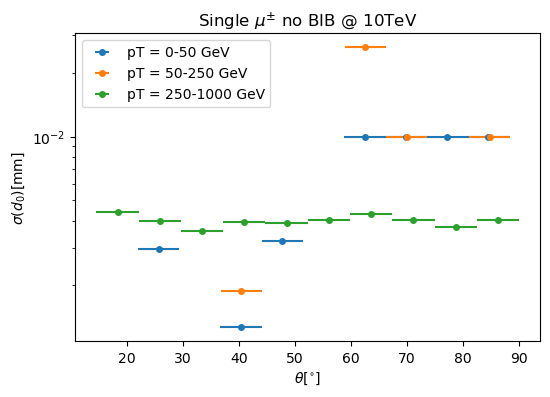

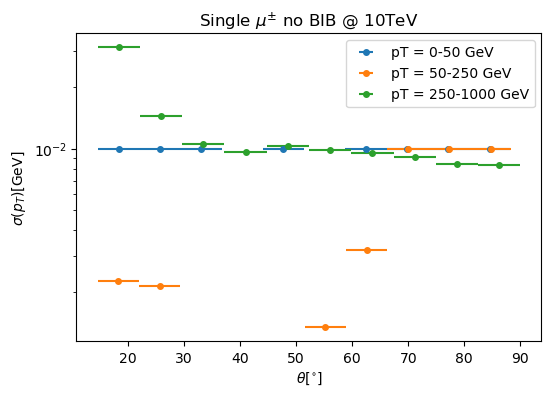

In [21]:
theta_all = [theta_0_50, theta_50_250, theta_match]
d0_all = [pt_0_50['d0_res_match'],pt_50_250['d0_res_match'],d0_res_match]
pt_all = [pt_0_50['pt_res'], pt_50_250['pt_res'],pt_res]
print(theta_all,d0_all)
theta_all_masked = []
d0_all_masked = []
pt_all_masked = []
for i in range(len(theta_all)):
    x = theta_all[i]
    y = d0_all[i]
    z = pt_all[i]
    # Create a boolean mask for the condition
    theta_cut = (0 <= x) & (x < 90)
    print(z)
    print(z[0])
    print(z[0][0])
    pt_res_cut = [np.abs(pt_resolution[0]) < 0.1 for pt_resolution in z]
    # Apply the mask to filter the arrays
    mask = theta_cut & pt_res_cut
    x_masked = x[mask]
    y_masked = y[mask]
    z_masked = z[mask]
    theta_all_masked.append(x_masked)
    d0_all_masked.append(y_masked)
    pt_all_masked.append(z_masked)

print(theta_all_masked,d0_all_masked)
plotrms_multi(theta_all_masked,d0_all_masked, bins = 10, labels = ['pT = 0-50 GeV', 'pT = 50-250 GeV', 'pT = 250-1000 GeV'], xlabel = r'$\theta[^{\circ}]$', ylabel = r'$\sigma(d_0)$[mm] ', title = r'Single $\mu^{\pm}$ no BIB @ 10TeV')
plotrms_multi(theta_all_masked,pt_all_masked, bins = 10, labels = ['pT = 0-50 GeV', 'pT = 50-250 GeV', 'pT = 250-1000 GeV'], xlabel = r'$\theta[^{\circ}]$', ylabel = r'$\sigma(p_T)$[GeV] ', title = r'Single $\mu^{\pm}$ no BIB @ 10TeV')

Slice 0: 250 to 1000
Mean from Fit: -0.0007651022185709459
Sigma from Fit: 0.009613746905659094
------------------------------------


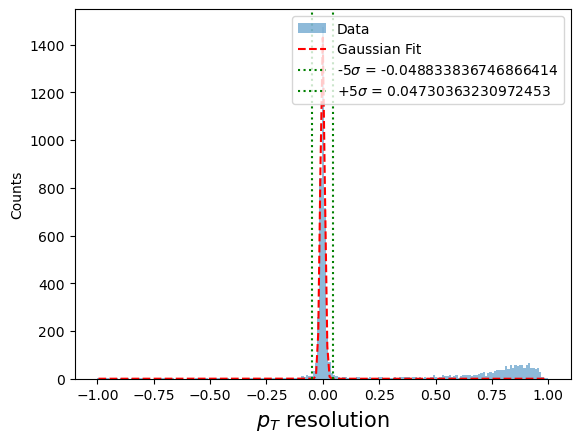

In [10]:
d0_bins = np.linspace(-0.1, 0.1, 300)
pT_bins = np.linspace(-1, 1, 200)
eta_bins = np.linspace(-2.7, 2.7, 100)
chi2ndf_bins = np.linspace(0, 2, 100)
nhits_bins = np.linspace(0, 20, 100)
x_bins = np.array([250,1000])
d0_title = r'$d_0$ resolution'
pT_title = r'$p_T$ resolution'
sigma,mean = plotrms_slice(pt_250_1000['pt_match'], pt_250_1000['pt_res'], x_bins = x_bins, bins=pT_bins, title=pT_title, rv = True, sigma5 = True)
#sigma,mean = plotrms_slice(pt_250_1000['pt_match'], pt_250_1000['d0_res_match'], x_bins = x_bins, bins=d0_bins, title=d0_title, rv = True, sigma5 = True)

### Comparing Bulk vs Tails 

In [11]:

spread = 5*np.abs(sigma)
print(np.mean(pt_res), np.std(pt_res))
pt_bulk = np.array([-1*spread+mean <= x[0] < spread+mean for x in pt_res]) 
pt_tails = np.array([x[0] < -1*spread+mean or x[0] >= spread+mean for x in pt_res])
d0_bulk = np.array([-1*spread+mean <= x[0] < spread+mean for x in d0_res_match])
d0_tails = np.array([x[0] < -1*spread+mean or x[0] >= spread+mean for x in d0_res_match])

-0.523320988896067 12.715776311952942


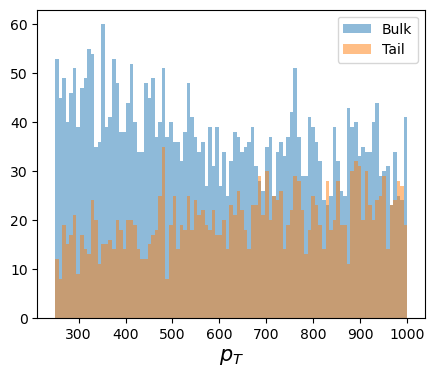

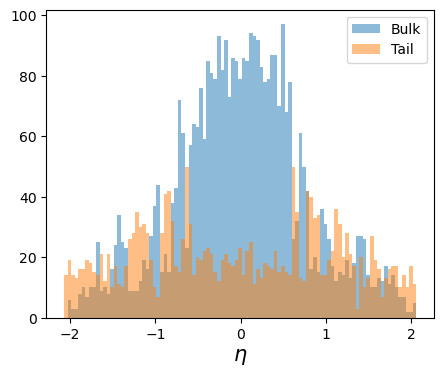

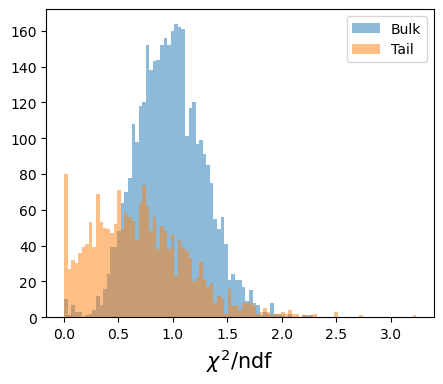

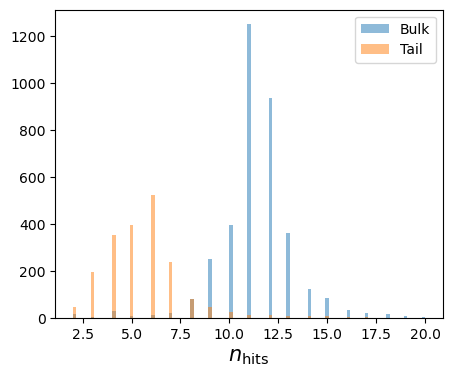

In [12]:
legends= ["Bulk", "Tail"]
c = 0
for x in [pt_match,eta_match,chi2/ndf, nhits]:
    arrays = [x[pt_bulk], x[pt_tails]]
    bins = np.linspace(np.min(x), np.max(x), 100)
    if c == 0:
        label = ';$p_{T}$'
    elif c == 1:
        label = r';$\eta$'
    elif c == 2:
        label = r';$\chi^2$/ndf'
    elif c == 3:
        label = r';$n_{\rm hits}$'
    c += 1
    compare1DHistograms(arrays, bins = bins, leg = legends, label = label)

### Plot 2D Hists showing resolution against $p_T$/$\eta$ and then the RMS of them against $\eta$

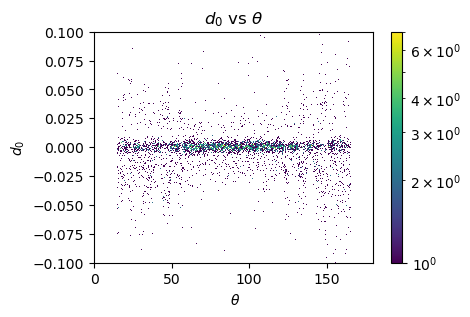

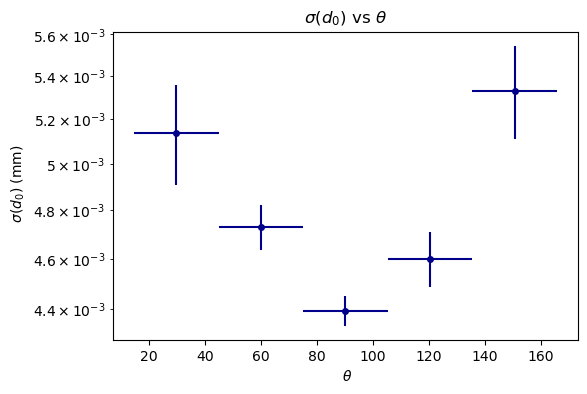

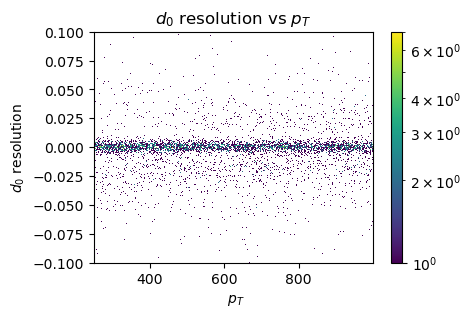

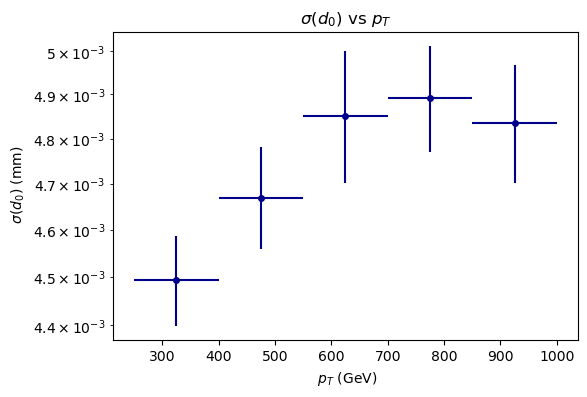

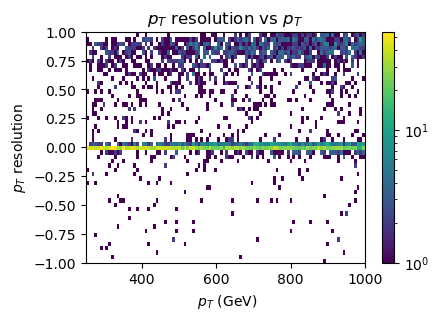

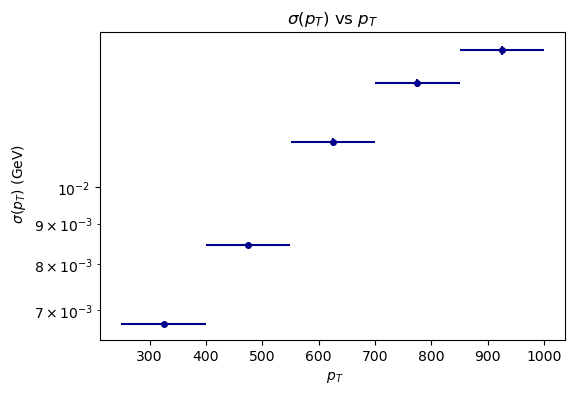

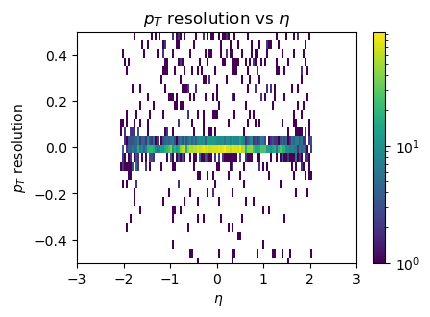

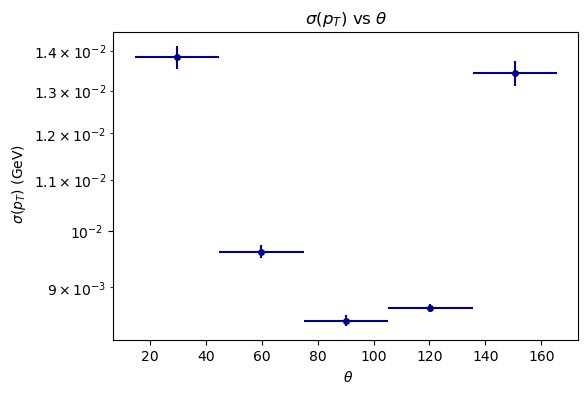

In [13]:
# # Histogram for mcp_eta
# plt.figure(figsize=(6, 3))

# plt.subplot(1, 2, 1)
# plt.hist((mcp_eta), bins=50, color='green')
# plt.xlabel('MCP $\\eta$')
# plt.ylabel('Count')
# plt.title('MCP $\\eta$ Distribution')

# # Histogram for mcp_phi
# plt.subplot(1, 2, 2)
# plt.hist((mcp_phi), bins=50, color='red')
# plt.xlabel('MCP $\\phi$')
# plt.ylabel('Count')
# plt.title('MCP $\\phi$ Distribution')

# # Adjust subplot spacing
# plt.tight_layout()

pt_xlim = [250,1000]
rms_bins = 5
plot2DHistogram(theta_match, d0_res_match, bins=(300,1000), label=r"$d_0$ vs $\theta$; $\theta$;$d_0$", xlim = (0,180), ylim = (-0.1,0.1))
plotrms(theta_match, d0_res_match, bins=rms_bins, label=r"$\sigma(d_0)$ vs $\theta$; $\theta$; $\sigma(d_0)$ (mm)")
plot2DHistogram(pt_match, d0_res_match, bins=(300,1000), label=r"$d_0$ resolution vs $p_T$; $p_T$;$d_0$ resolution", ylim = (-0.1,0.1))#, xlim = (0,1000), ylim = (-0.1,0.1))
plotrms(pt_match, d0_res_match, bins=rms_bins, label=r"$\sigma(d_0)$ vs $p_T$; $p_T$ (GeV); $\sigma(d_0)$ (mm)", xlim = pt_xlim)
# plot2DHistogram(eta_match, z0_res_match, bins=(100,1000), label=r"$z_0$ resolution vs $\eta$; $\eta$;$z_0$ resolution", xlim = (-3,3), ylim = (-0.1,0.1))
# plotrms(eta_match, z0_res_match, bins=rms_bins, label=r"$\sigma(z_0)$ vs $\eta$; $\eta$; $\sigma(z_0)$")
# plot2DHistogram(pt_match, z0_res_match, bins=(100,1000), label=r"$z_0$ resolution vs $p_T$; $p_T$;$z_0$ resolution", xlim = pt_xlim, ylim = (-0.1,0.1))
# plotrms(pt_match, z0_res_match, bins=rms_bins, label=r"$\sigma(z_0)$ vs $p_T$; $p_T$; $\sigma(z_0)$", xlim = pt_xlim)
plot2DHistogram(pt_match, pt_res, bins=(100,15000), label=r"$p_T$ resolution vs $p_T$; $p_T$ (GeV);$p_T$ resolution", xlim = pt_xlim, ylim = (-1,1))
plotrms(pt_match, pt_res, bins=rms_bins, label=r"$\sigma(p_T)$ vs $p_T$; $p_T$; $\sigma(p_T)$ (GeV)", xlim = pt_xlim)
plot2DHistogram(eta_match, pt_res, bins=(100,15000), label=r"$p_T$ resolution vs $\eta$; $\eta$;$p_T$ resolution", xlim = (-3,3), ylim = (-0.5,0.5))
plotrms(theta_match, pt_res, bins=rms_bins, label=r"$\sigma(p_T)$ vs $\theta$; $\theta$; $\sigma(p_T)$ (GeV)")

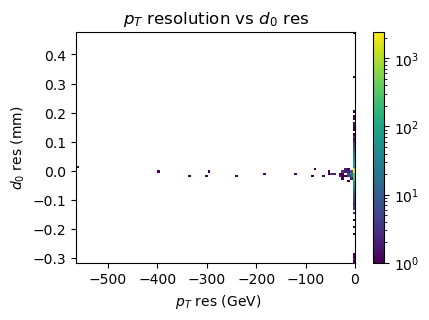

Text(0.5, 1.0, 'Track $d_0$ Resolution')

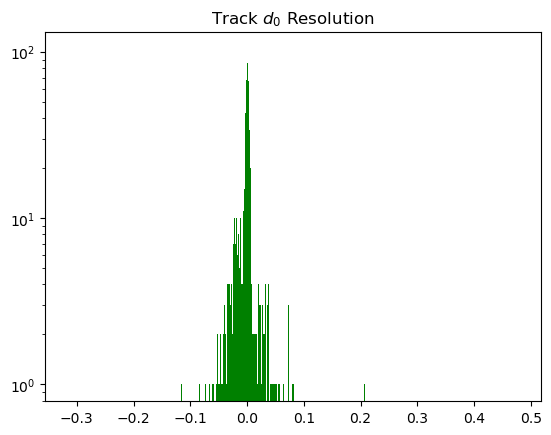

In [14]:
plot2DHistogram(pt_res, d0_res_match, bins=(100,100), label=r"$p_T$ resolution vs $d_0$ res; $p_T$ res (GeV);$d_0$ res (mm)")
plt.hist((np.ravel(d0_res_match)), bins=5000, color='green')
plt.yscale('log')
#plt.xlim(-1,1)
#plt.ylim(0,200)
plt.title('Track $d_0$ Resolution')

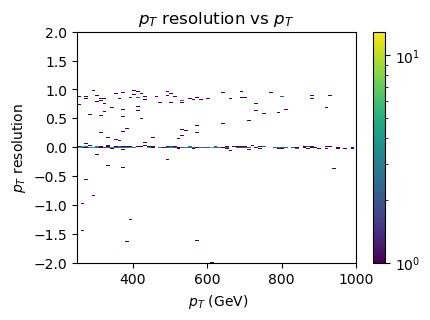

7.059196147303414
12.715776311952942


C:\Users\leoro\AppData\Local\Temp\ipykernel_28884\2422915615.py:8: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,200)


Text(0.5, 1.0, 'Track $p_T$ Resolution')

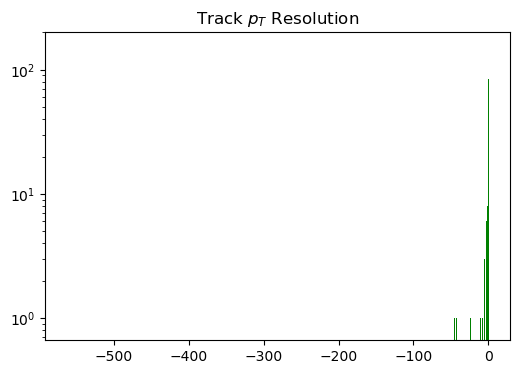

In [15]:
plot2DHistogram(legacy['pt_match'], legacy['pt_res'],bins=(100,15000), label=r"$p_T$ resolution vs $p_T$; $p_T$ (GeV);$p_T$ resolution", xlim = [250,1000], ylim = (-2,2))
plt.figure(figsize=(6, 4))
print(np.sqrt(np.mean(np.square(legacy['pt_res'] - np.mean(legacy['pt_res'])))))
print(np.std(pt_res))
plt.hist((np.ravel(pt_res)), bins=5000, color='green')
plt.yscale('log')
#plt.xlim(-1,1)
plt.ylim(0,200)
plt.title('Track $p_T$ Resolution')